# Imports básicos para todas as análises

In [2]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [3]:
import  pandas as pd,               \
        numpy as np,                \
        matplotlib.pyplot as plt,   \
        requests as rt,             \
        seaborn as sns,             \
        xml.etree.ElementTree as ET

from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from xgboost import XGBRegressor, plot_importance

from neuralforecast         import NeuralForecast
from neuralforecast.auto    import AutoLSTM, AutoNHITS
from neuralforecast.models  import LSTM, NHITS
from neuralforecast.losses.pytorch import DistributionLoss, SMAPE

from sklearn.metrics import r2_score, mean_squared_error

from sktime.utils.plotting import plot_series
#from sktime.forecasting.compose import make_reduction
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Ajustes feitos para geração e criação de gráfico
sns.set_style('darkgrid')
# rcParams['figure.figsize'] = 15, 6
rcParams['figure.figsize'] = 20, 10

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

2024-02-05 14:35:54,769	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-05 14:35:55,177	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Utilidades

In [4]:
# Retirado de: <https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/common/utils.py>

from collections import UserDict

class TimeSeriesStructure(UserDict):
    """
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.values
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].values
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [5]:
class DataSet():
    
    def __init__(self, file, adjust=True):
        self.df = pd.read_csv(file, sep='\t', index_col=0, header=0, parse_dates=['ds'])

        if adjust:
            self.df = self.df.resample('D').first() # deixando a série contínua numa base diária
            self.df.fillna(self.df.mean(), inplace=True) # isso, possivelmente, criará lacunas com "NaN" e precisa executar este passo

        # ==================================================================================== #
        # Estes atributos são para aplicação em Aprendizado Supervisionado (Machine Learning)
        # Também dá pra usar em Deep Learning com a lib Keras
        self.ml_inputs = None # Este atributo receberá um objeto da classe "TimeSeriesStructure"       
        self.ml_train = None
        self.ml_validation = None
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.X_validation = None
        self.y_validation = None
        # ==================================================================================== #

        # ==================================================================================== #
        # Estes atributos, já ajustados, são para Deep Learning com a lib NeuralForecast
        self.dl_inputs = self.df.copy()
        self.dl_inputs['unique_id'] = 1.0
        self.dl_inputs.reset_index(inplace=True)
        self.dl_train = None
        self.dl_validation = None


    # O corte realizado por esse método é simples: pega do início da série até 'train_size' e coloca no DataFrame 'train'.
    # O que resta do corte é colocado no DataFrame 'validation'
    def split_train_test(self, dataframe, train_size=0.7):

        # Tamanho total da série
        size = dataframe.shape[0]

        # Tamanho do treino
        t_size = int(size * train_size)

        train = dataframe.iloc[0:t_size]
        validation = dataframe.iloc[t_size:]

        return train, validation

# Alto Doce

## Carregando os dados para análise

In [6]:
ds_alto = DataSet('alto_doce.csv')
ds_alto.df.describe()

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
count,3683.000000,3683.00000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000
mean,120.963956,2.90080,69.662090,2.667560,71.762139,2.295398,28.032810,0.045096,254.083439,2.877480,115.548849,3.277873,61.976891
std,123.811284,9.48174,65.914976,7.136782,59.072915,5.834512,28.915250,0.449132,2.527514,7.864615,110.591662,8.015500,60.153906
min,17.410000,0.00000,9.791935,0.000000,0.000000,0.000000,0.000000,0.000000,190.820000,0.000000,21.340000,0.000000,10.058000
25%,59.818000,0.00000,30.884896,0.000000,39.444375,0.000000,10.192120,0.000000,254.035853,0.000000,71.138043,0.000000,29.494000
50%,85.107000,0.00000,52.265625,2.100000,71.762139,1.400000,28.032810,0.000000,254.035853,2.000000,115.548849,3.277873,45.371000
75%,134.837000,0.40000,74.283958,2.667560,71.762139,2.295398,30.081330,0.045096,254.083439,2.877480,115.548849,3.277873,65.381000
max,2000.467000,139.20000,806.008148,111.200000,949.781250,100.000000,261.545833,16.700000,377.050000,192.200000,1936.280000,172.400000,849.711000


In [7]:
ds_alto.df

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
ds,,,,,,,,,,,,,
2013-01-01,82.787,0.0,49.475000,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,60.056000
2013-01-02,80.489,0.0,46.957143,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000
2013-01-03,78.214,0.0,46.721875,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000
2013-01-04,79.349,0.0,49.183333,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000
2013-01-05,129.161,0.0,49.780208,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27,648.940,0.8,388.402708,0.80000,369.873333,2.400000,120.202917,0.000000,311.915263,0.00000,565.199583,0.200000,61.976891
2023-01-28,520.591,0.0,263.569896,0.00000,244.310833,0.000000,111.370833,0.000000,243.242500,2.60000,387.516250,0.000000,61.976891
2023-01-29,424.853,0.0,242.208229,0.00000,216.592083,0.000000,93.840417,0.000000,190.820000,0.00000,321.508333,0.000000,61.976891


## Análise exploratória dos dados

### Decomposição da Série Temporal da vazão 'y' (estação principal)

A decomposição da série temporal principal ('y'/'target') ajuda a detectar padrões e identificar outras informações que podem ajudar na interpretação do que está acontecendo

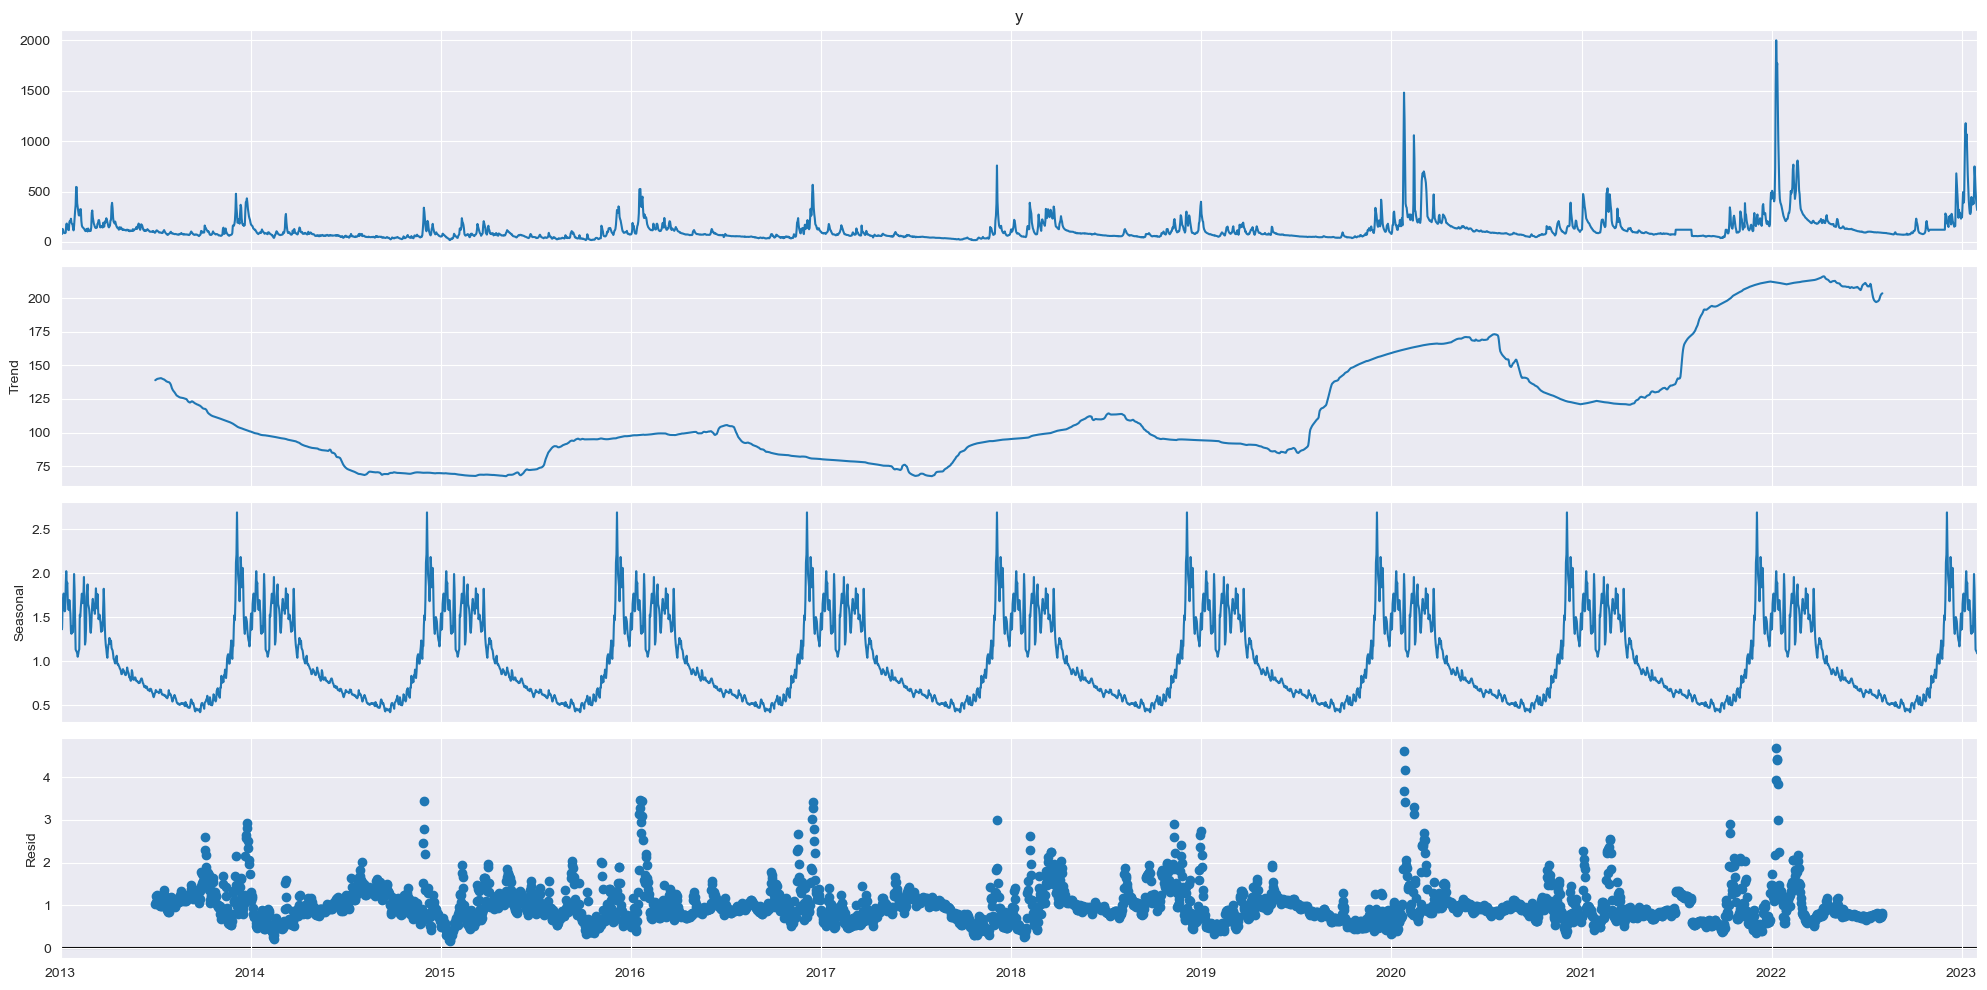

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

vazao_y = seasonal_decompose(ds_alto.df['y'], period=365, model="mult")
vazao_y.plot() # este ';' é macetão pra não plotar duplicado este gráfico.
plt.show()

### Teste de estacionariedade da vazão 'y'

Novamente. Identificar informações, comportamento da Série Temporal em anaálise

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ds_alto.df['y'])

if result[1] <= 0.05:
    print("ESTACIONÁRIA")
else:
    print("NÃO ESTACIONÁRIA")

ESTACIONÁRIA


In [10]:
# Mapa de correlação do DataFrame
ds_alto.df.corr().style.background_gradient(cmap='coolwarm')

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
y,1.000000,0.268765,0.925556,0.268953,0.864723,0.246664,0.405192,-0.039812,0.069295,0.181228,0.886830,0.187818,0.845410
chuva1,0.268765,1.000000,0.270683,0.552330,0.225275,0.492518,0.205762,0.032928,-0.001726,0.390331,0.266706,0.399461,0.271507
vazao1,0.925556,0.270683,1.000000,0.238439,0.857252,0.225226,0.398863,-0.041772,0.084366,0.178644,0.844699,0.207285,0.870007
chuva2,0.268953,0.552330,0.238439,1.000000,0.246980,0.597748,0.268420,0.086183,-0.003044,0.532358,0.315741,0.403620,0.180795
vazao2,0.864723,0.225275,0.857252,0.246980,1.000000,0.202504,0.404864,-0.038198,0.090402,0.162788,0.928386,0.201542,0.753145
chuva3,0.246664,0.492518,0.225226,0.597748,0.202504,1.000000,0.264566,0.089278,-0.000904,0.519031,0.262896,0.293118,0.174690
vazao3,0.405192,0.205762,0.398863,0.268420,0.404864,0.264566,1.000000,-0.041096,0.046113,0.213777,0.405526,0.149993,0.306674
chuva4,-0.039812,0.032928,-0.041772,0.086183,-0.038198,0.089278,-0.041096,1.000000,-0.001068,0.083350,-0.038392,0.029414,-0.041734
vazao4,0.069295,-0.001726,0.084366,-0.003044,0.090402,-0.000904,0.046113,-0.001068,1.000000,-0.001990,0.074197,-0.004194,-0.001247
chuva5,0.181228,0.390331,0.178644,0.532358,0.162788,0.519031,0.213777,0.083350,-0.001990,1.000000,0.211561,0.287275,0.177663


In [11]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(ds_alto.df)
# analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Após análise com ajuda do SweetViz, removi as colunas "chuva4" e "vazao4" porque, de tanta lacuna e preenchimento com média,<br/>
elas foram detectadas como categóricas e pouco tinham de relação com as demais informações.

In [12]:
ds_alto.df.drop(columns=["chuva4", "vazao4"], inplace=True)

In [13]:
# ds_alto.df

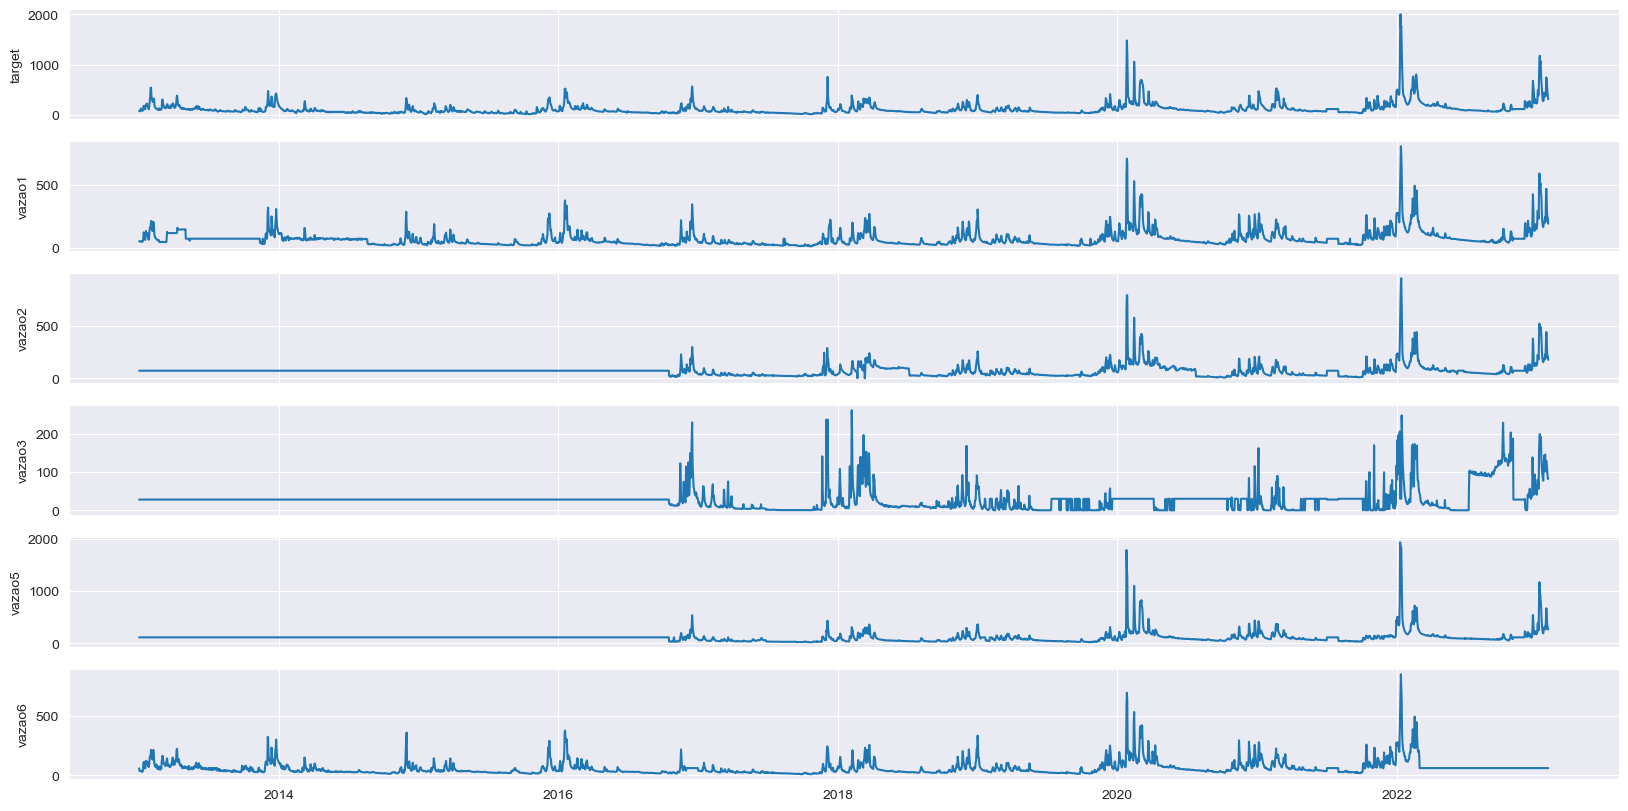

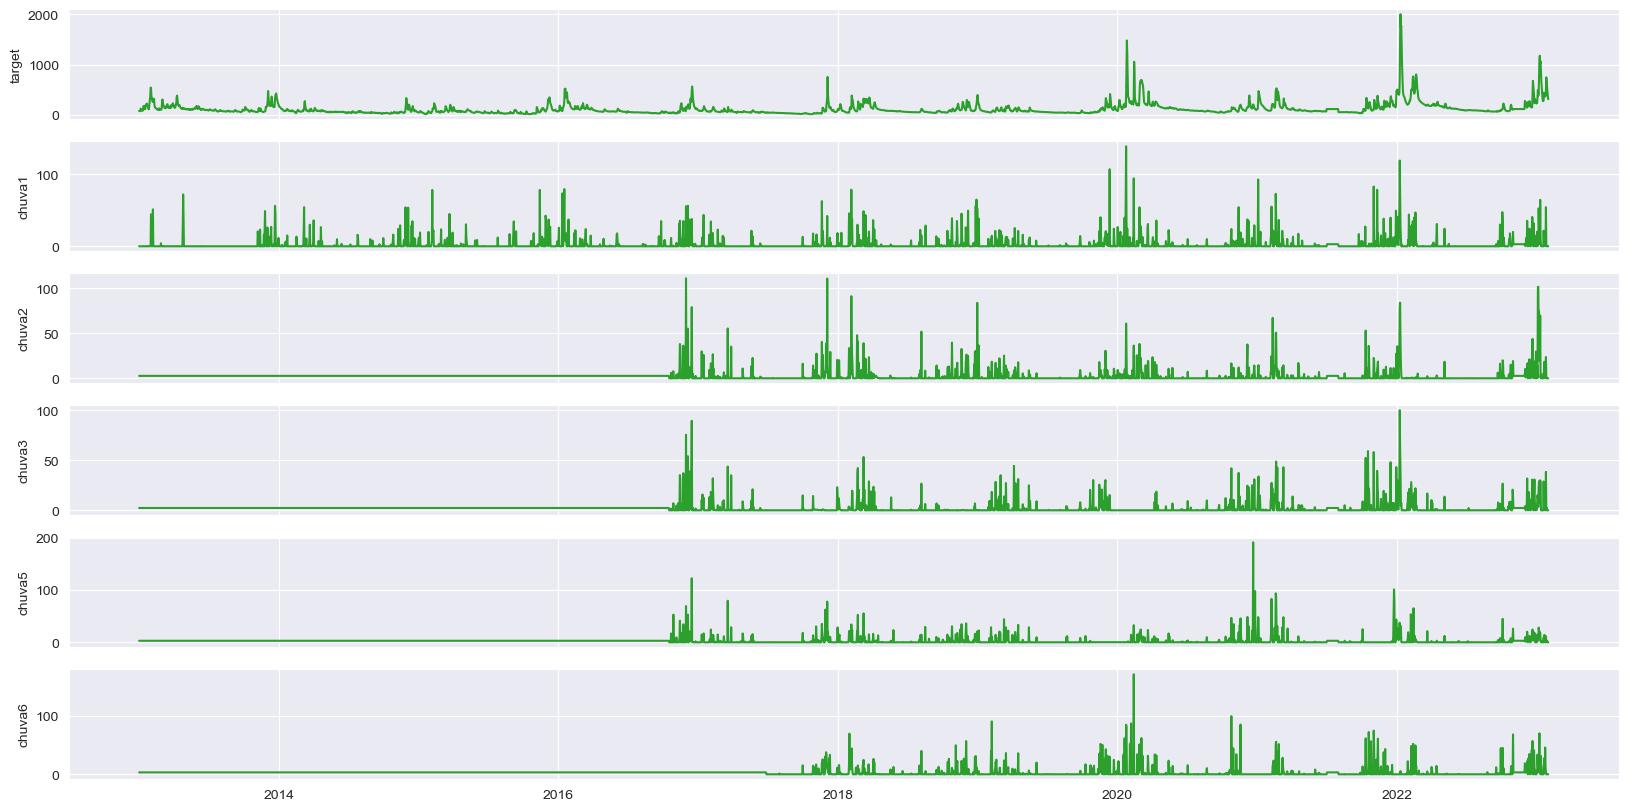

In [14]:
fig, vazoes = plt.subplots(6)
vazoes[0].plot(ds_alto.df.index, ds_alto.df['y'])
vazoes[0].set(ylabel='target')

vazoes[1].plot(ds_alto.df.index, ds_alto.df['vazao1'])
vazoes[1].set(ylabel='vazao1')

vazoes[2].plot(ds_alto.df.index, ds_alto.df['vazao2'])
vazoes[2].set(ylabel='vazao2')

vazoes[3].plot(ds_alto.df.index, ds_alto.df['vazao3'])
vazoes[3].set(ylabel='vazao3')

vazoes[4].plot(ds_alto.df.index, ds_alto.df['vazao5'])
vazoes[4].set(ylabel='vazao5')

vazoes[5].plot(ds_alto.df.index, ds_alto.df['vazao6'])
vazoes[5].set(ylabel='vazao6')

for ax in vazoes.flat:
    ax.label_outer()

#########

fig, chuvas = plt.subplots(6)
chuvas[0].plot(ds_alto.df.index, ds_alto.df['y'], 'tab:green')
chuvas[0].set(ylabel='target')

chuvas[1].plot(ds_alto.df.index, ds_alto.df['chuva1'], 'tab:green')
chuvas[1].set(ylabel='chuva1')

chuvas[2].plot(ds_alto.df.index, ds_alto.df['chuva2'], 'tab:green')
chuvas[2].set(ylabel='chuva2')

chuvas[3].plot(ds_alto.df.index, ds_alto.df['chuva3'], 'tab:green')
chuvas[3].set(ylabel='chuva3')

chuvas[4].plot(ds_alto.df.index, ds_alto.df['chuva5'], 'tab:green')
chuvas[4].set(ylabel='chuva5')

chuvas[5].plot(ds_alto.df.index, ds_alto.df['chuva6'], 'tab:green')
chuvas[5].set(ylabel='chuva6')

for ax in chuvas.flat:
    ax.label_outer()

### Formatando os dados para o Aprendizado Supervisionado

In [15]:
# Parâmetros para gerar um objeto TimeSeriesStructure

T = 5 # usará X lag(s) anterior(es)
HORIZON = 1 # vai prever Y dia(s) à frente
N_FEATURES = ds_alto.df.columns.size # As features são todas as colunas do dataset com os dados de todas as estações juntos

In [16]:
data_structure = {'X' : (range(-T+1, 1), ds_alto.df.columns.values)}
data_structure

{'X': (range(-4, 1),
  array(['y', 'chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3',
         'chuva5', 'vazao5', 'chuva6', 'vazao6'], dtype=object))}

In [17]:
ds_alto.ml_inputs = TimeSeriesStructure(ds_alto.df, 'y', HORIZON, tensor_structure=data_structure, freq='D')

ds_alto.X = ds_alto.ml_inputs.dataframe['X']
ds_alto.y = ds_alto.ml_inputs.dataframe['target']

ds_alto.ml_inputs.dataframe

tensor       target        X                                                   \
feature           y        y                                     chuva1         
time step       t+1      t-4      t-3      t-2      t-1        t    t-4   t-3   
ds                                                                              
2013-01-05  117.231   82.787   80.489   78.214   79.349  129.161    0.0   0.0   
2013-01-06   93.402   80.489   78.214   79.349  129.161  117.231    0.0   0.0   
2013-01-07   91.005   78.214   79.349  129.161  117.231   93.402    0.0   0.0   
2013-01-08   87.450   79.349  129.161  117.231   93.402   91.005    0.0   0.0   
2013-01-09   87.450  129.161  117.231   93.402   91.005   87.450    0.0   0.0   
...             ...      ...      ...      ...      ...      ...    ...   ...   
2023-01-26  648.940  370.758  422.803  376.640  472.934  749.032    2.8   0.2   
2023-01-27  520.591  422.803  376.640  472.934  749.032  648.940    0.2   4.2   
2023-01-28  424.853  376.640  472.934  749.032  648.940  520.591    4.2  54.4   
2023-01-29  362.965  472.934  749.032  648.940  520.591  424.853   54.4   1.0   
2023-01-30  316.521  749.032  648.940  520.591  424.853  362.965    1.0   0.8   

tensor                  ...                                             \
feature                 ...     chuva6                                   
time step    t-2   t-1  ...        t-4        t-3        t-2       t-1   
ds                      ...                                              
2013-01-05   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-06   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-07   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-08   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-09   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
...          ...   ...  ...        ...        ...        ...       ...   
2023-01-26   4.2  54.4  ...   1.600000  46.200000  12.200000  3.600000   
2023-01-27  54.4   1.0  ...  46.200000  12.200000   3.600000  0.000000   
2023-01-28   1.0   0.8  ...  12.200000   3.600000   0.000000  0.200000   
2023-01-29   0.8   0.0  ...   3.600000   0.000000   0.200000  0.000000   
2023-01-30   0.0   0.0  ...   0.000000   0.200000   0.000000  0.000000   

tensor                                                                       
feature                  vazao6                                              
time step          t        t-4        t-3        t-2        t-1          t  
ds                                                                           
2013-01-05  3.277873  60.056000  37.546000  39.228000  37.546000  39.228000  
2013-01-06  3.277873  37.546000  39.228000  37.546000  39.228000  39.228000  
2013-01-07  3.277873  39.228000  37.546000  39.228000  39.228000  38.383000  
2013-01-08  3.277873  37.546000  39.228000  39.228000  38.383000  32.714000  
2013-01-09  3.277873  39.228000  39.228000  38.383000  32.714000  29.671000  
...              ...        ...        ...        ...        ...        ...  
2023-01-26  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-27  0.200000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-28  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-29  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-30  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  

[3678 rows x 56 columns]

In [18]:
# Separando em TREINO e VALIDAÇÃO
ds_alto.ml_train, ds_alto.ml_validation = ds_alto.split_train_test(ds_alto.ml_inputs.dataframe, 0.8)

ds_alto.X_train = ds_alto.ml_train['X']
ds_alto.y_train = ds_alto.ml_train['target']

ds_alto.X_validation = ds_alto.ml_validation['X']
ds_alto.y_validation = ds_alto.ml_validation['target']

# ds_alto.X_train.shape, ds_alto.y_train.shape, ds_alto.X_validation.shape, ds_alto.y_validation.shape

##### Fazendo scaling dos dados de entrada

Os resultados estão muito distantes. O XGboost está tendo um resultado absurdamente bom enquanto que a rede LSTM está completamente perdida.
Vou tentar escalar os dados de entrada e comparar. É sabido que redes LSTM não se comportam bem com dados em escalas grandes e díspares, como neste caso, em que a chuva, em mm, tem valores minúsculos, e vazão em $m^3$/s.

A expectativa é que se comporte melhor.

#### XGBoost

XGBoost Vanilla, sem nenhuma otimização

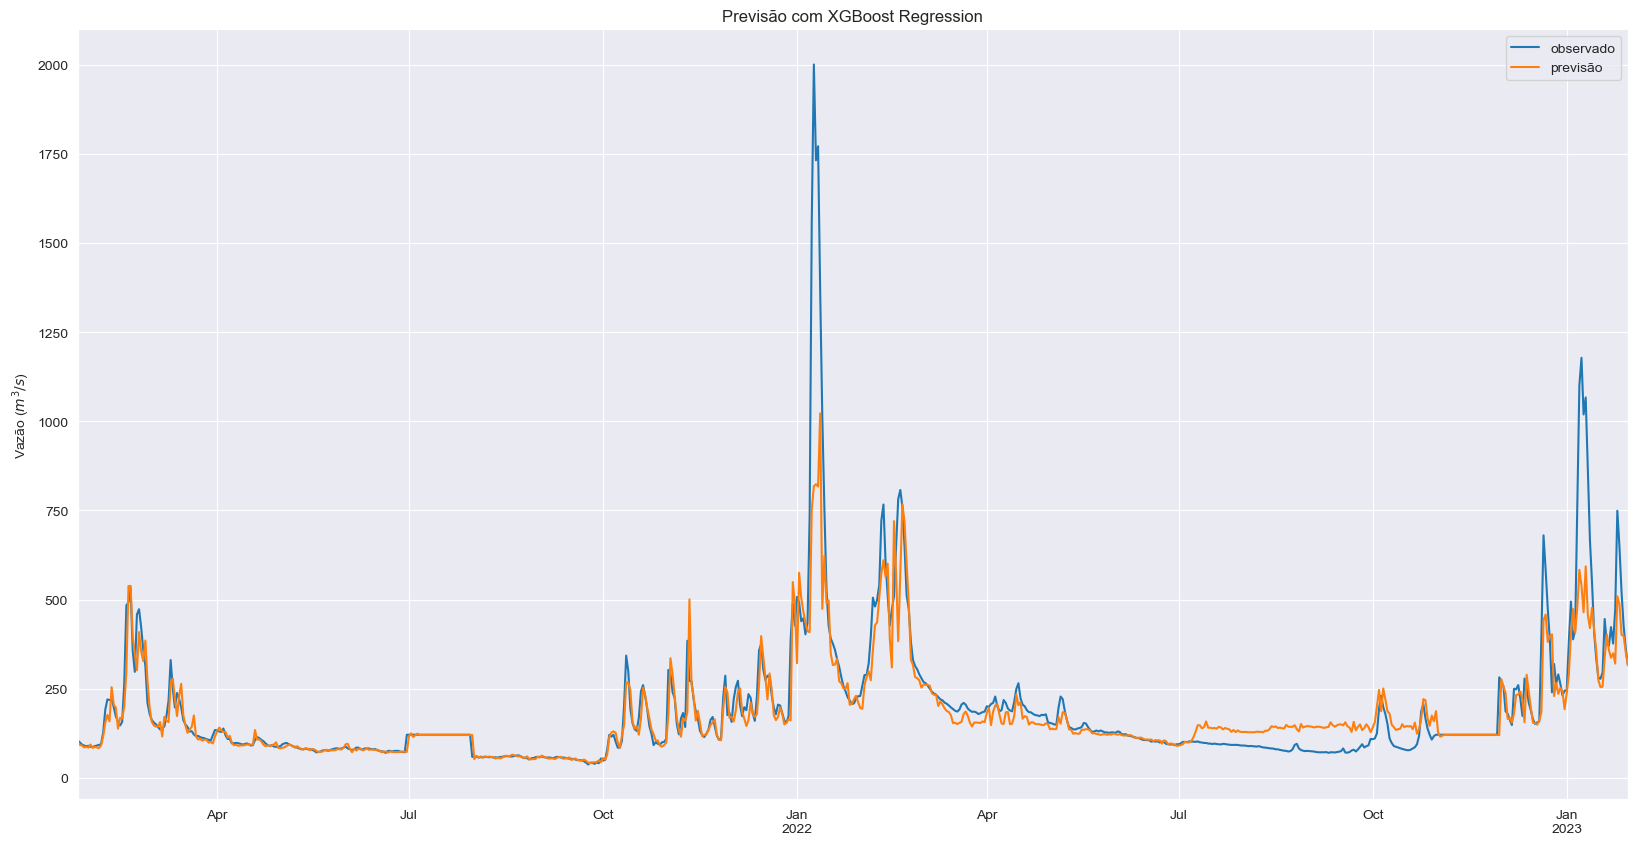

(0.163619408237444, 0.737787486501564, 101.03007194001259)

In [122]:
v_model = XGBRegressor()
v_model.fit(ds_alto.X_train, ds_alto.y_train)

vanilla_xgb = pd.DataFrame(data=v_model.predict(ds_alto.X_validation), columns=['pred'])
vanilla_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
vanilla_xgb['ds'] = ds_alto.ml_validation.index

vanilla_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
plt.title('Previsão com XGBoost Regression')
plt.xlabel('')
plt.ylabel('Vazão ($m^3/s$)')
plt.legend()
plt.show()

smape(vanilla_xgb['obs'], vanilla_xgb['pred']), r2_score(vanilla_xgb['obs'], vanilla_xgb['pred']), np.sqrt(mean_squared_error(vanilla_xgb['obs'], vanilla_xgb['pred']))

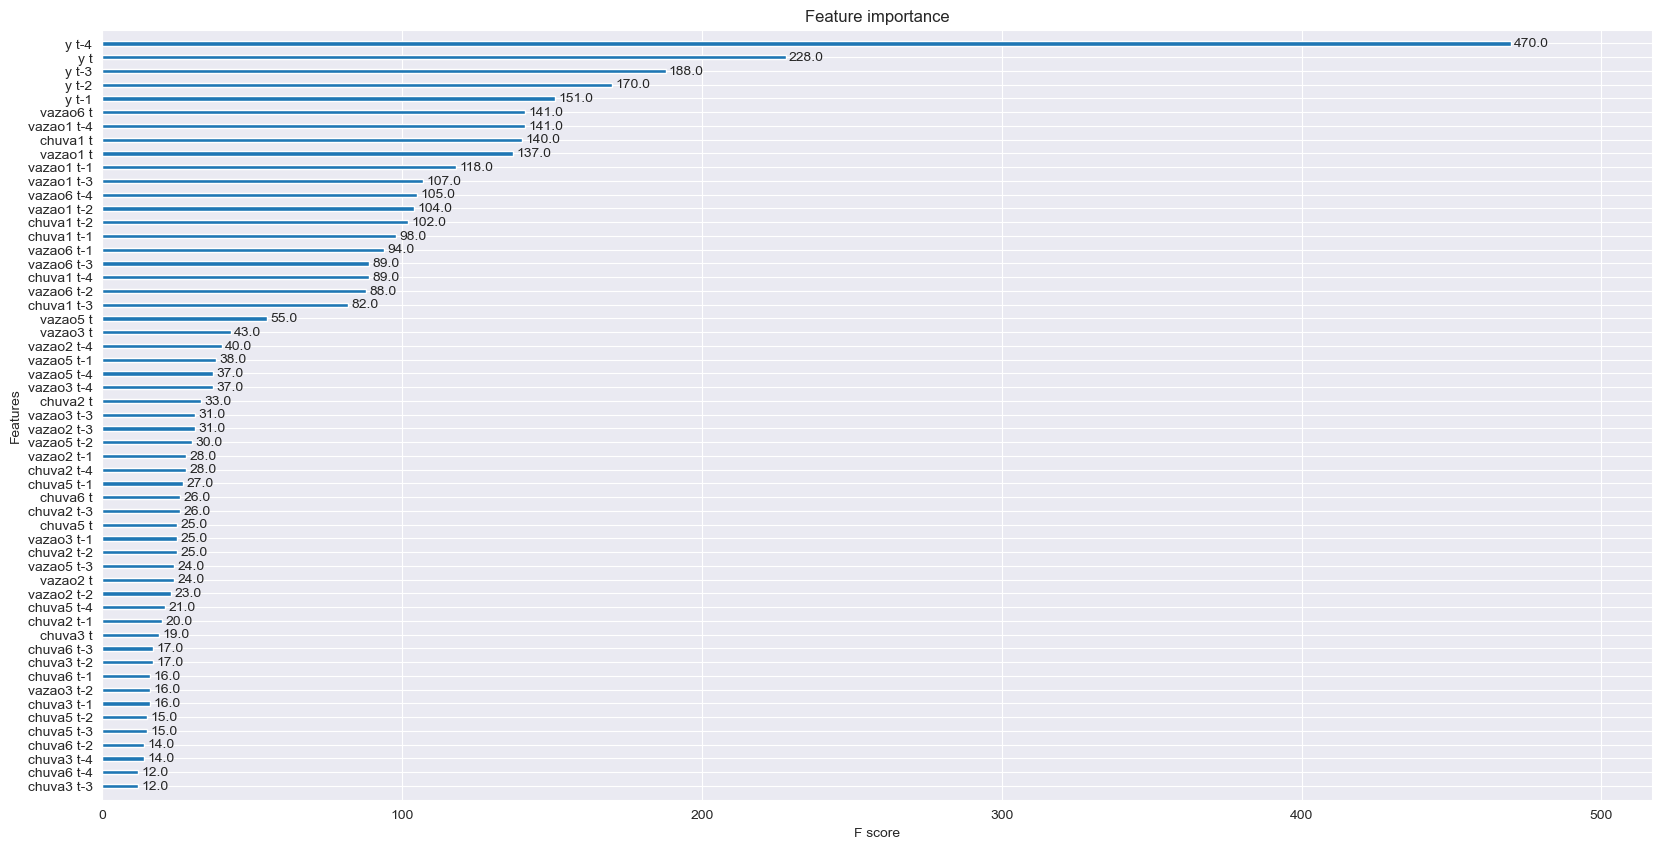

In [123]:
# Feature Selection

plot_importance(v_model, height=0.3)
plt.show()

#### Otimizar o modelo XGBRegressor

**Tree-specific hyperparameters control the construction and complexity of the decision trees:**

<u>max_depth</u>: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting. <<range: [0,∞]>>

<u>min_child_weight</u>: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. <<range: [0,∞]>>

<u>subsample</u>: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data. <<range: (0,1]>>

<u>colsample_bytree</u>: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. <<range: (0, 1]>>
<br/><br/><br/><br/>
**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**

<u>eta (also known as learning rate)</u>: step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps. <<range: [0,1]>>

<u>gamma</u>: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. <<range: [0,∞]>>

<u>lambda</u>: L2 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

<u>alpha</u>: L1 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

In [124]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [125]:
# np.linspace(0, 1, 10)

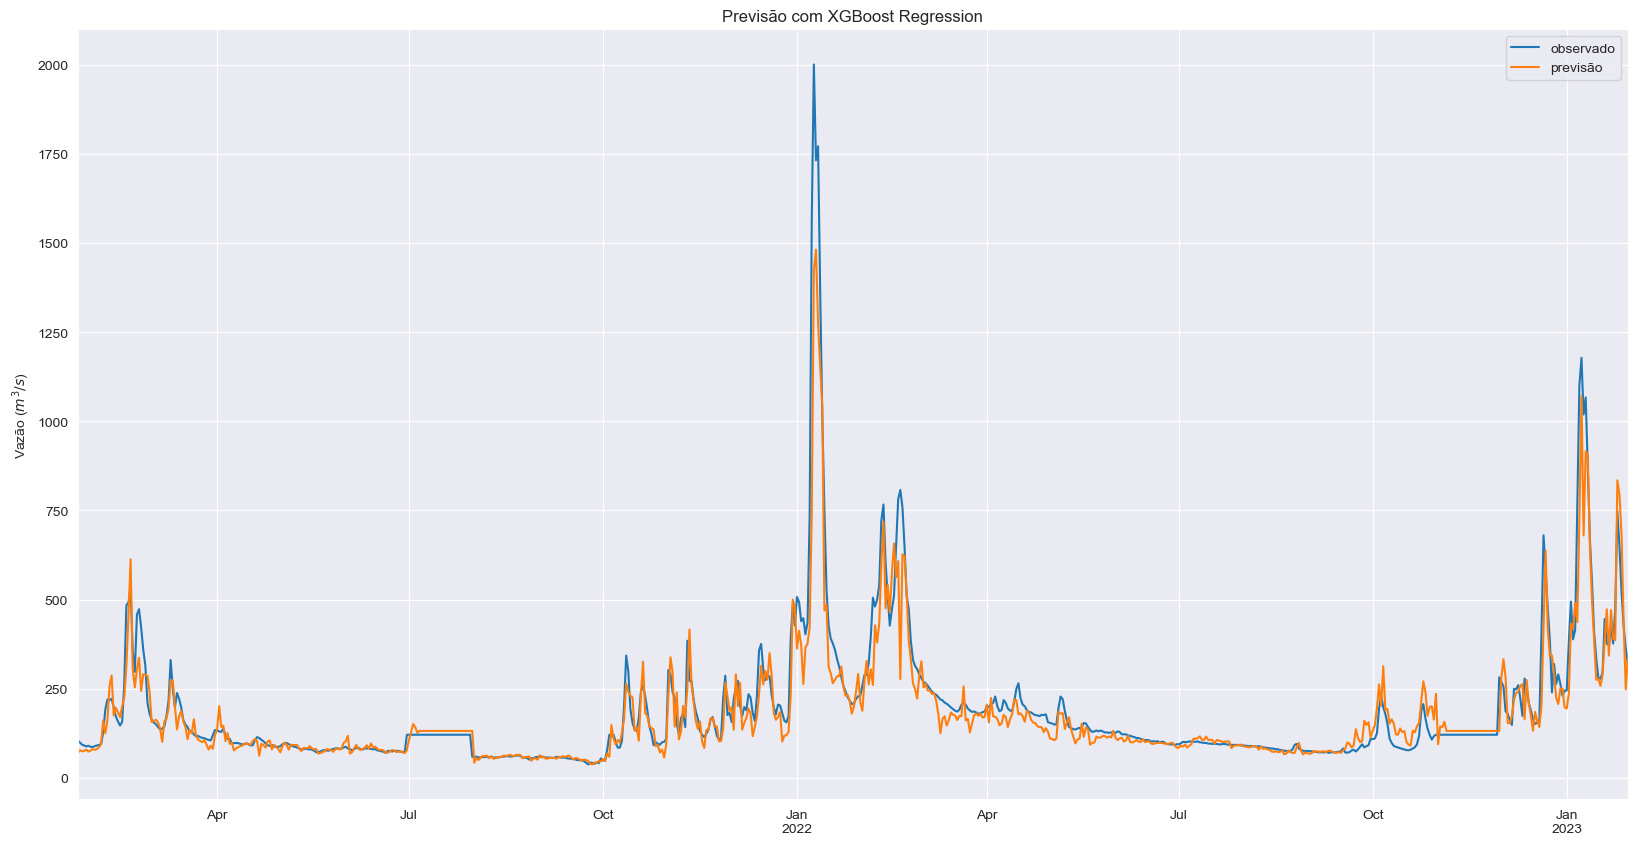

(0.14948289507314416, 0.8747351780138517, 69.82943341092718)

In [126]:
# Tree-specific hyperparameters control the construction and complexity of the decision trees

grid_params = {
    'max_depth' : [0, 222, 444, 666, 888, 1111, 1333, 1555, 1777, 2000],
    'min_child_weight' : [0, 222, 444, 666, 888, 1111, 1333, 1555, 1777, 2000],
    'subsample' : [0.01, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 1],
    'colsample_bytree' : [0.01, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 1]
}

t_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

# Tree optimized booster
tree_grid_search = GridSearchCV(t_model, param_grid=grid_params, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
tree_grid_search.fit(ds_alto.X_train, ds_alto.y_train)

tree_xgb = pd.DataFrame(data=tree_grid_search.predict(ds_alto.X_validation), columns=['pred'])
tree_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
tree_xgb['ds'] = ds_alto.ml_validation.index

tree_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
plt.title('Previsão com XGBoost Regression')
plt.xlabel('')
plt.ylabel('Vazão ($m^3/s$)')
plt.legend()
plt.show()

smape(tree_xgb['obs'], tree_xgb['pred']), r2_score(tree_xgb['obs'], tree_xgb['pred']), np.sqrt(mean_squared_error(tree_xgb['obs'], tree_xgb['pred']))

In [133]:
print("Melhor conjunto de hiperparâmetros: ", tree_grid_search.best_params_)
# print("Best score: ", tree_grid_search.best_score_)

Melhor conjunto de hiperparâmetros:  {'colsample_bytree': 0.44, 'max_depth': 222, 'min_child_weight': 0, 'subsample': 0.33}


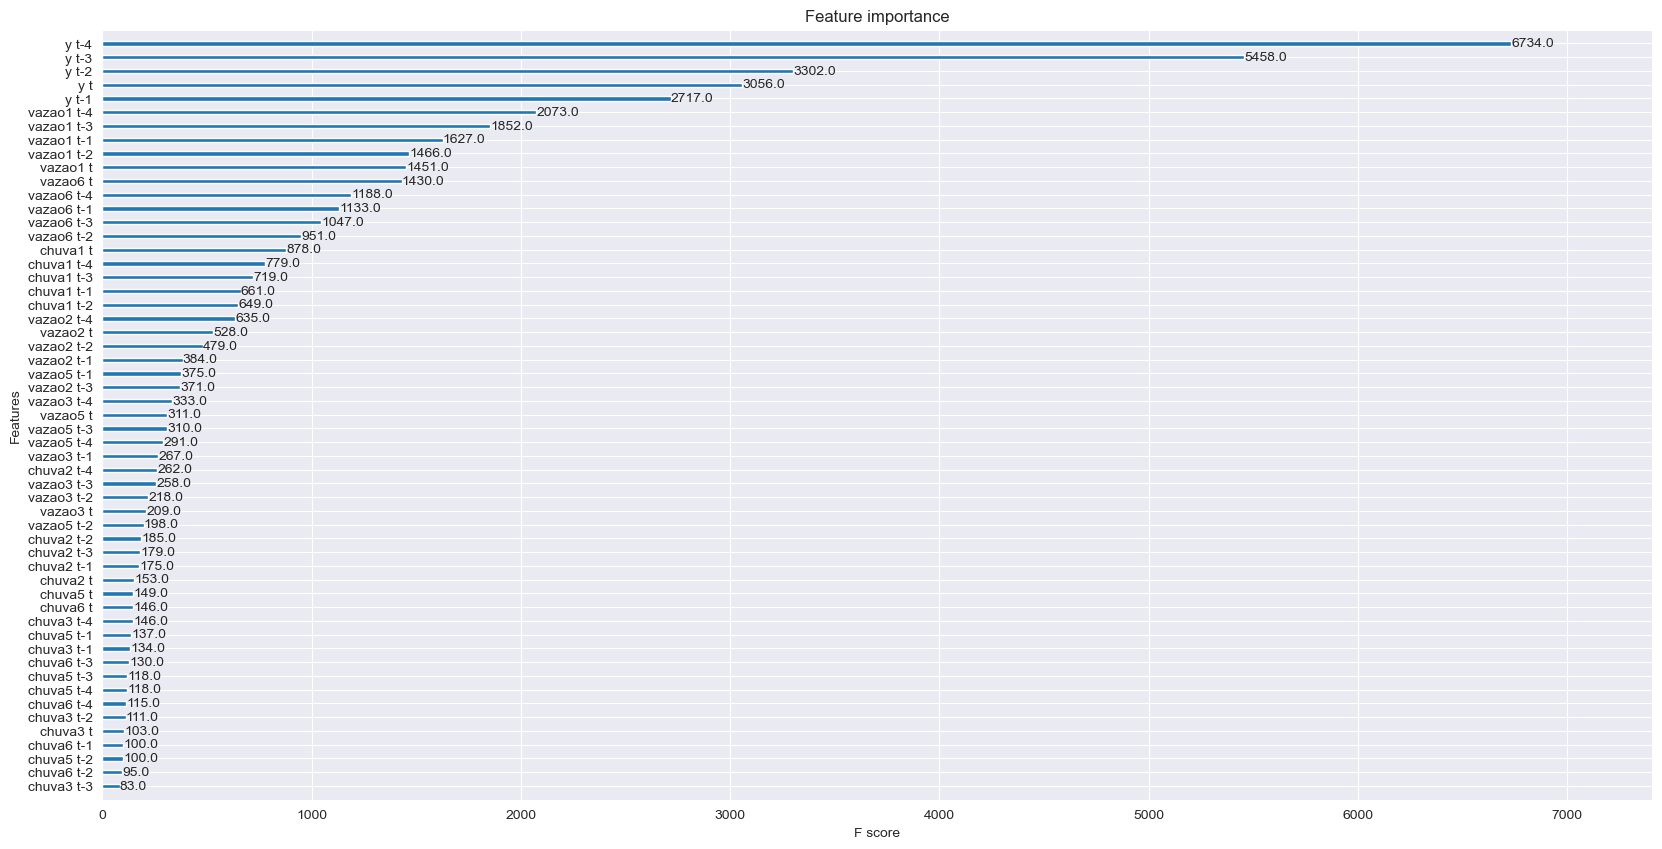

In [127]:
# Feature Selection

plot_importance(tree_grid_search.best_estimator_, height=0.3)
plt.show()

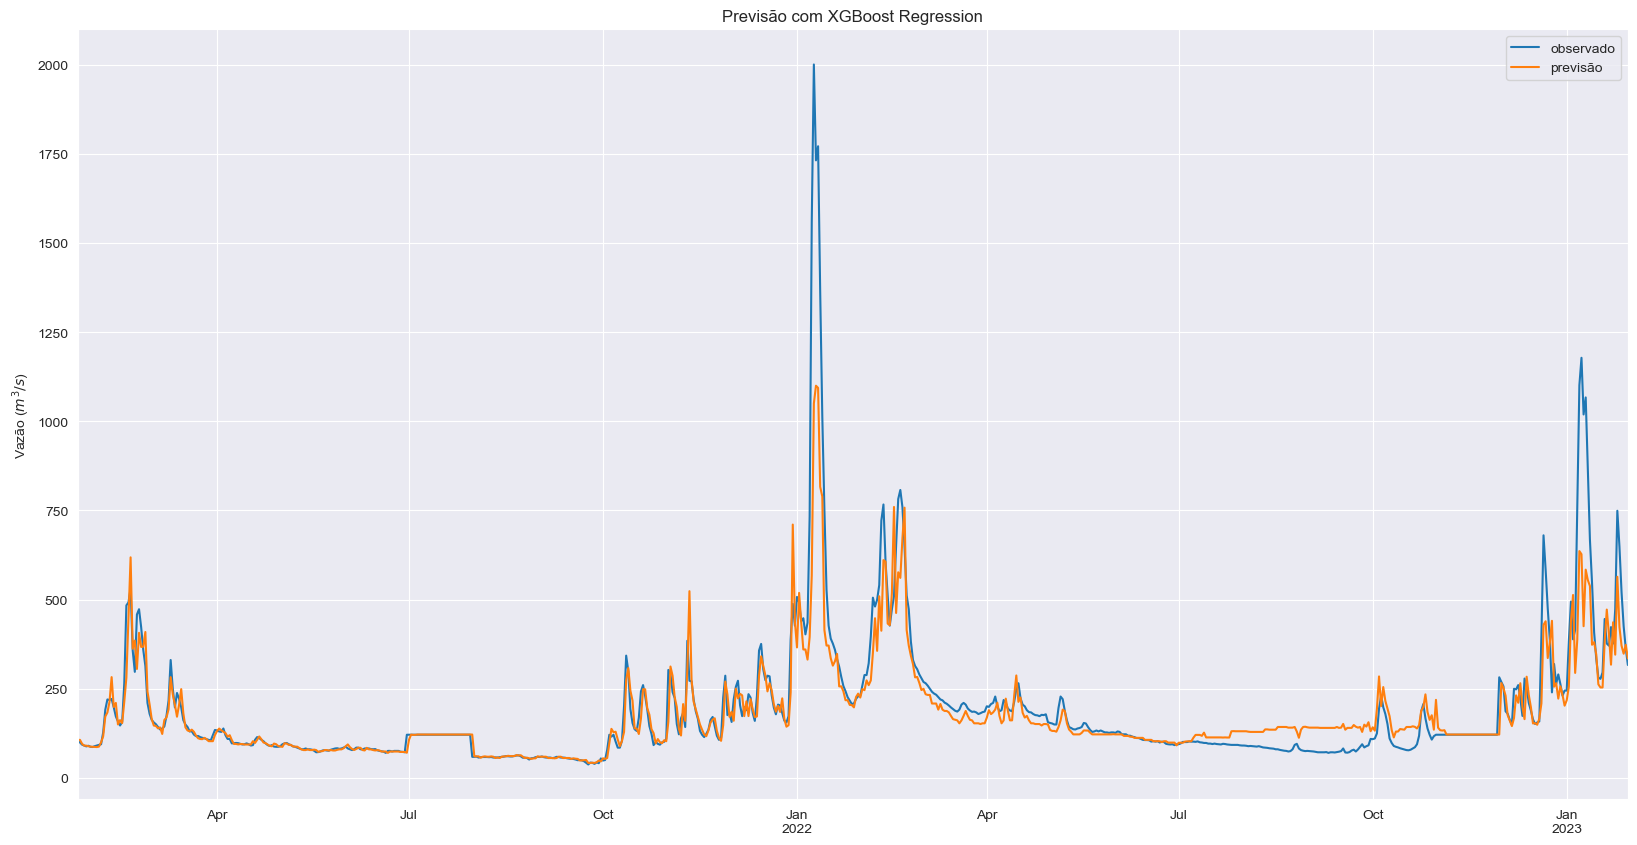

(0.15574775506791225, 0.7752237834517337, 93.54038086575792)

In [128]:
# Learning task-specific hyperparameters control the overall behavior of the model and the learning process

grid_params = {
    'learning_rate' : [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 1e-0],
    'gamma' : [0, 555, 1111, 1666, 2222, 2777, 3333, 3888, 4444, 5000],
    'reg_lambda' : [0, 555, 1111, 1666, 2222, 2777, 3333, 3888, 4444, 5000],
    'alpha' : [0, 555, 1111, 1666, 2222, 2777, 3333, 3888, 4444, 5000]
}

l_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

learning_grid_search = GridSearchCV(l_model, param_grid=grid_params, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
learning_grid_search.fit(ds_alto.X_train, ds_alto.y_train)

learning_xgb = pd.DataFrame(data=learning_grid_search.predict(ds_alto.X_validation), columns=['pred'])
learning_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
learning_xgb['ds'] = ds_alto.ml_validation.index

learning_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
plt.title('Previsão com XGBoost Regression')
plt.xlabel('')
plt.ylabel('Vazão ($m^3/s$)')
plt.legend()
plt.show()

smape(learning_xgb['obs'], learning_xgb['pred']), r2_score(learning_xgb['obs'], learning_xgb['pred']), np.sqrt(mean_squared_error(learning_xgb['obs'], learning_xgb['pred']))

In [134]:
print("Melhor conjunto de hiperparâmetros: ", learning_grid_search.best_params_)
# print("Best score: ", learning_grid_search.best_score_)

Melhor conjunto de hiperparâmetros:  {'alpha': 0, 'gamma': 4444, 'learning_rate': 0.2, 'reg_lambda': 0}


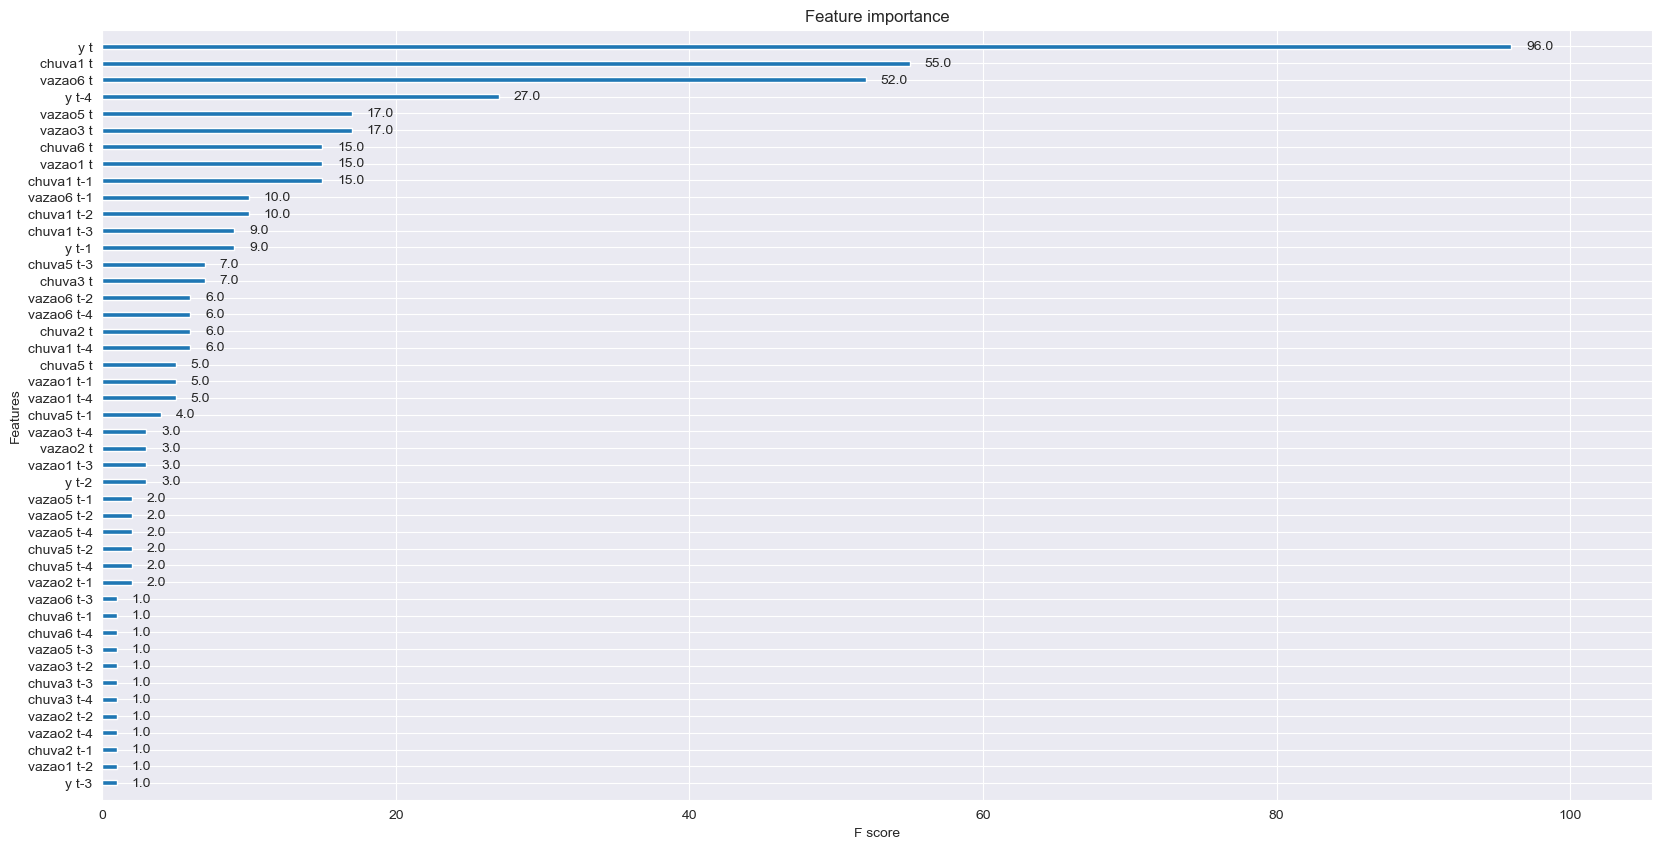

In [129]:
# Feature Selection

plot_importance(learning_grid_search.best_estimator_, height=0.3)
plt.show()

#### Rede LSTM

Aplicação da biblioteca NeuralForecast

In [20]:
training_size = round(len(ds_alto.dl_inputs) * 0.8) # 80% de treinamento / 20% de validação
fch = len(ds_alto.dl_inputs) - training_size
len(ds_alto.dl_inputs), training_size, fch

# ds_alto.dl_inputs

(3683, 2946, 737)

In [21]:
ds_alto.dl_train  = ds_alto.dl_inputs[:training_size]
ds_alto.dl_validation = ds_alto.dl_inputs[training_size:]

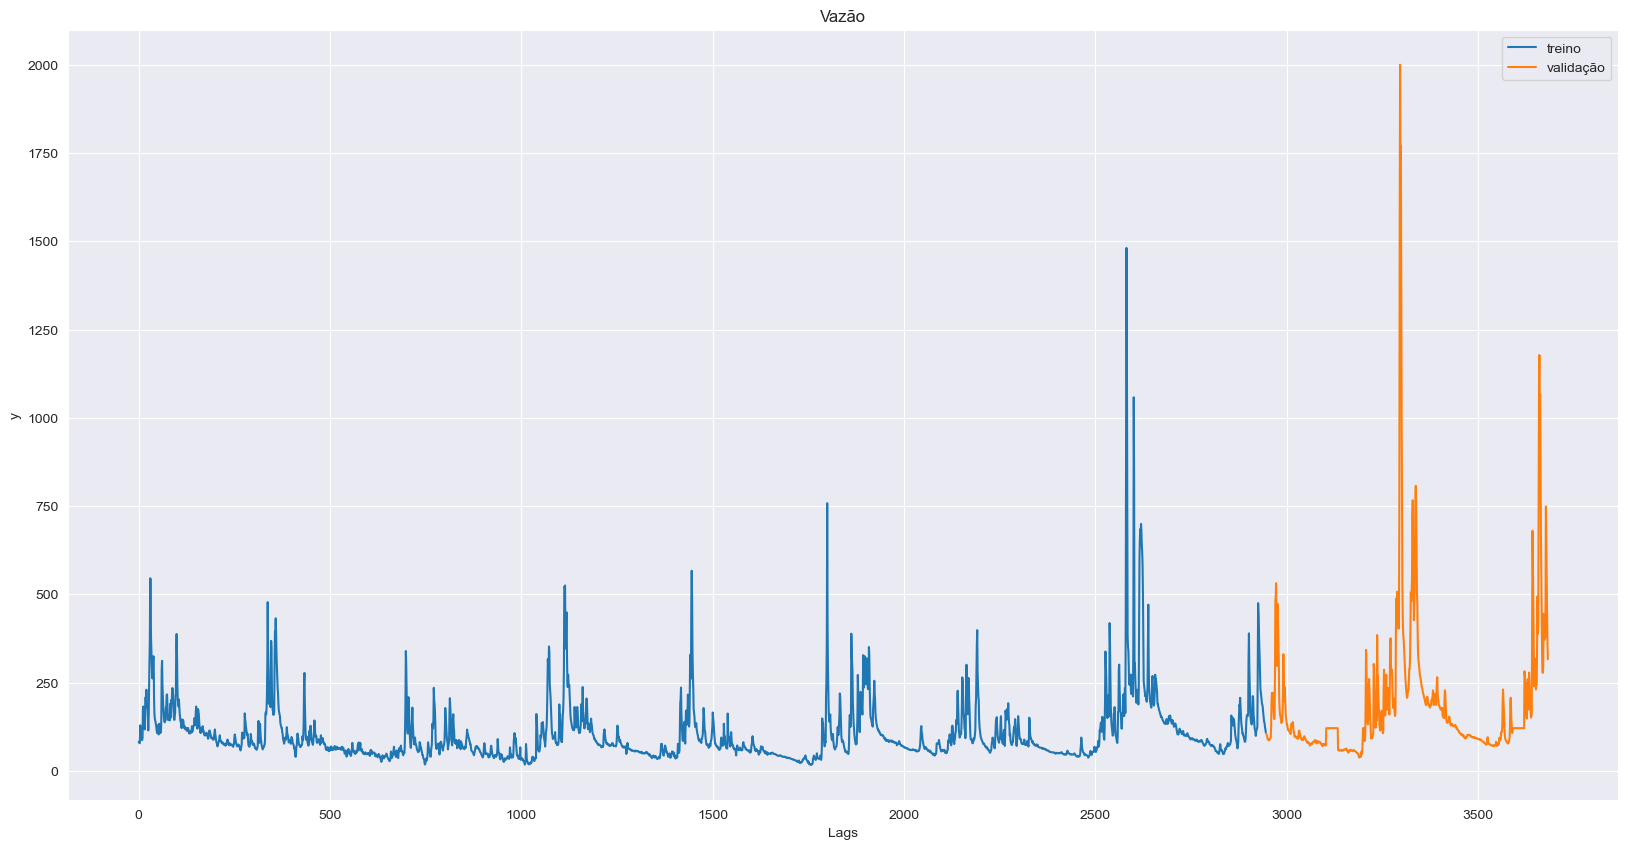

In [22]:
ds_alto.dl_train['y'].plot(label='treino')
ds_alto.dl_validation['y'].plot(label='validação')
plt.title('Vazão')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

In [213]:
models = [
          LSTM(h=fch,                        # Forecast horizon // X dias
               max_steps=100,                # Number of steps to train (epochs)
               # loss=DistributionLoss(distribution='Normal', level=[80, 90]), # Usando a função de perda do DeepAR (famosa)
               loss=SMAPE(),
               scaler_type='robust',       # Type of scaler to normalize data
            #    hist_exog_list=['chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6'],
               futr_exog_list=['chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6'],
               encoder_hidden_size=64,      # Defines the size of the hidden state of the LSTM
               encoder_n_layers=1,
               decoder_hidden_size=64,      # Defines the number of hidden units of each layer of the MLP decoder
               decoder_layers=1,
               context_size=5)               # usa os X dias anteriores para prever adiante.

      #     NHITS(h=fch,                       # Forecast horizon
      #           input_size=2 * len(df_test), # Length of input sequence
      #           max_steps=300,               # Number of steps to train
      #           n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=ds_alto.dl_train)

Global seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it, v_num=41, train_loss_step=0.323, train_loss_epoch=0.323]


In [26]:
futr_df = ds_alto.dl_validation[['ds', 'unique_id', 'chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6']]
futr_df

,ds,unique_id,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
2946,2021-01-25,1.0,0.0,59.679167,0.0,35.587500,0.0,0.000000,0.0,254.035853,0.0,98.458333,0.0,58.694000
2947,2021-01-26,1.0,0.0,58.070833,0.0,34.837500,0.0,0.000000,0.0,254.035853,0.0,97.133333,0.0,54.380000
2948,2021-01-27,1.0,0.0,56.911458,0.0,33.150000,0.0,0.000000,0.0,254.035853,0.2,91.685417,0.0,54.851000
2949,2021-01-28,1.0,0.0,54.156250,0.0,31.795833,0.0,0.000000,0.0,254.035853,0.0,90.097917,0.0,52.062000
2950,2021-01-29,1.0,0.0,54.375000,0.0,31.104167,0.0,0.000000,0.0,254.035853,0.0,88.810417,0.0,54.380000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2023-01-27,1.0,0.8,388.402708,0.8,369.873333,2.4,120.202917,0.0,311.915263,0.0,565.199583,0.2,61.976891
3679,2023-01-28,1.0,0.0,263.569896,0.0,244.310833,0.0,111.370833,0.0,243.242500,2.6,387.516250,0.0,61.976891
3680,2023-01-29,1.0,0.0,242.208229,0.0,216.592083,0.0,93.840417,0.0,190.820000,0.0,321.508333,0.0,61.976891
3681,2023-01-30,1.0,0.0,227.691875,0.0,206.661667,0.2,81.679167,0.0,228.868824,0.0,299.070417,0.0,61.976891


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


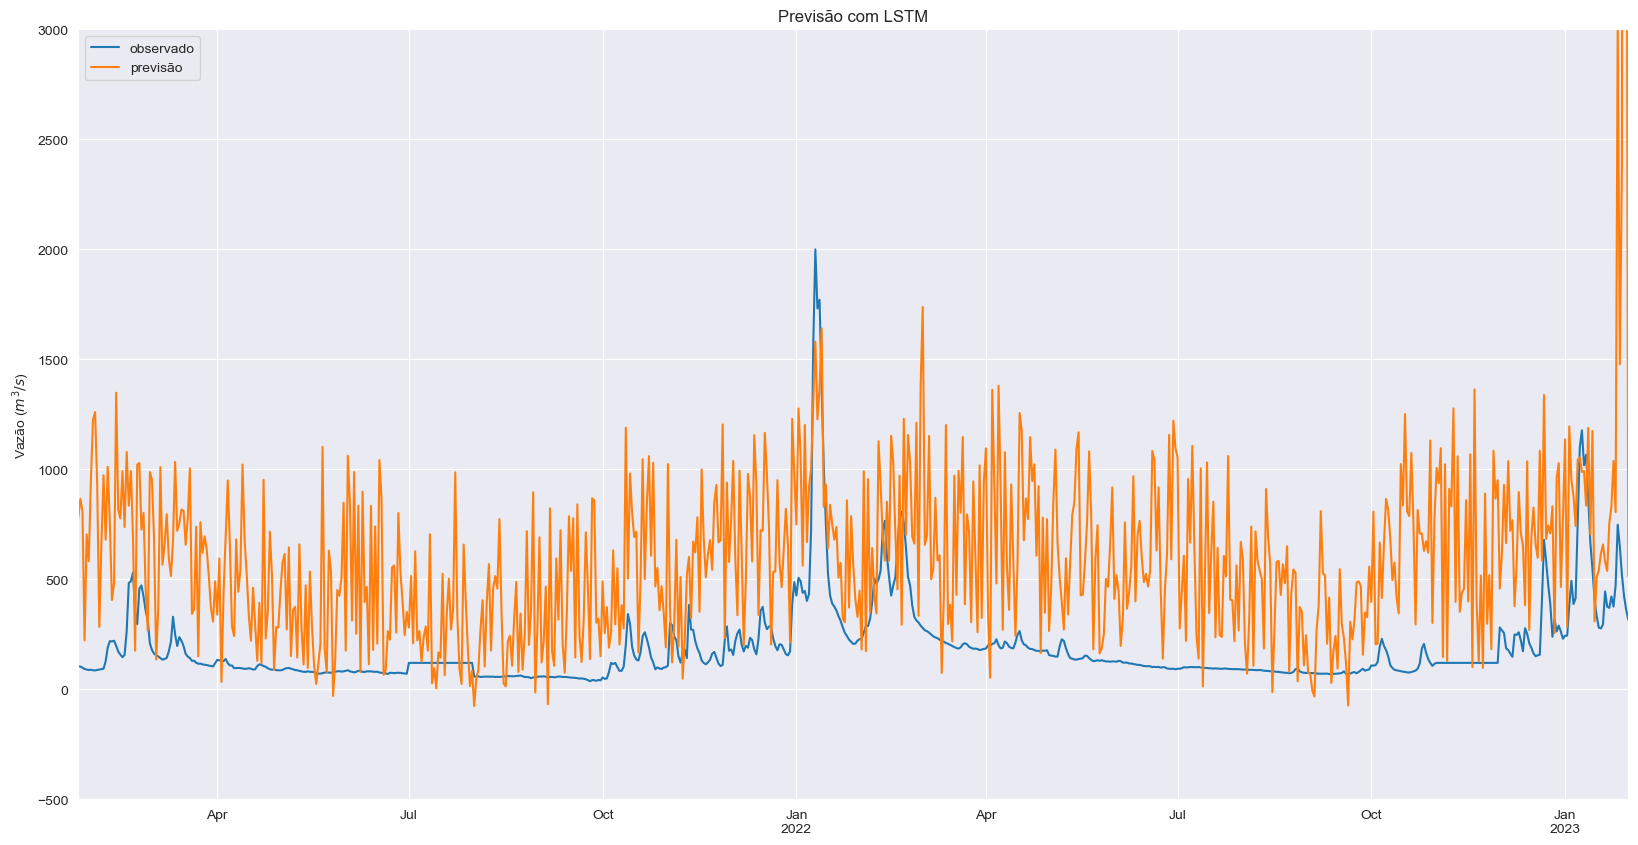

(1.0564329657117972, -11.196607041499336, 688.6534323223246)

In [217]:
neural_df = nf.predict(futr_df=futr_df)
# plot_df = pd.concat([ds_alto.dl_validation['y'], neural_df]).set_index('ds') # Concatenate the train and forecast dataframes
neural_df ['obs'] = ds_alto.dl_validation['y'].values

neural_df
# plot_df

# neural_df.plot('ds', ['obs', 'LSTM'], label=['observado', 'previsão'], ylim=[-500,3000])
# plt.title('Previsão com LSTM')
# plt.xlabel('')
# plt.ylabel('Vazão ($m^3/s$)')
# plt.legend()
# plt.show()

# smape(neural_df['obs'].values, neural_df['LSTM'].values), r2_score(neural_df['obs'], neural_df['LSTM']), np.sqrt(mean_squared_error(neural_df['obs'], neural_df['LSTM']))

In [25]:
# Testando o AutoLSTM para detecção dos melhores parâmetros

models_auto = [AutoLSTM(h=fch,
                        loss=SMAPE(),
                        num_samples=10)]

m_auto = NeuralForecast(models=models_auto, freq='D')

In [27]:
m_auto.fit(df=ds_alto.dl_train, val_size=7)

(_train_tune pid=14060) Global seed set to 12


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250]        


2024-02-05 14:28:30,024	WARNING syncer.py:586 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:33:32,004	WARNING syncer.py:586 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:34:29,656	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-02-05 14:34:29,661	WARNING tune.py:1122 -- Trial Runner checkpointing failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:34:39,777	WARNING tune.py:1163 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="c://\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19", trainable=...)
2024-02-05 14:34:39,801	WARNING experiment_analysis.py:916 -- Failed to read the results for 10 trials:
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00000_0_batch_size=16,context_size=10,decoder_hidden_size=256,encoder_hidden_size=200,encoder_n_layers=2,inferen_2024-02-05_14-23-27
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00001_1_batch_size=32,context_size=5,decoder_hidden_size=512,encoder_hidden_size=100,encoder_n_layers=3,inferenc_2024-02-05_14-23-27
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00002_2_batch_size=16,context_size=50,decoder_hidden_size=256,encoder_hidden_size=200,encoder_n_layers=1,inferen_2024-02-05_14-23-27
- C:\Users\welso

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

# Médio Doce